In [1]:
%pip install yfinance

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [4]:
np.random.seed(42)

In [5]:
nvda = yf.download("NVDA", start="2015-01-01", end="2025-11-13")

/tmp/ipython-input-1337492881.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda = yf.download("NVDA", start="2015-01-01", end="2025-11-13")
[*********************100%***********************]  1 of 1 completed


In [6]:
nvda.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2015-01-02,0.483038,0.486638,0.475360,0.483038,113680000
2015-01-05,0.474880,0.484478,0.472720,0.483038,197952000
2015-01-06,0.460482,0.476080,0.460002,0.475600,197764000
2015-01-07,0.459282,0.467921,0.457843,0.463842,321808000
2015-01-08,0.476559,0.479439,0.464321,0.464561,283780000


In [8]:
#결측치 체크
nvda.isnull().sum()

,,0
Price,Ticker,
Close,NVDA,0
High,NVDA,0
Low,NVDA,0
Open,NVDA,0
Volume,NVDA,0


In [9]:
nvda['Returns'] = nvda['Close'].pct_change()
nvda['LogReturns'] = np.log(nvda['Close'] / nvda['Close'].shift(1))
nvda['MA20'] = nvda['Close'].rolling(window=20).mean()
nvda['MA60'] = nvda['Close'].rolling(window=60).mean()
nvda['Volatility20'] = nvda['Returns'].rolling(window=20).std()
nvda['Volatility'] = nvda['Volatility20']* np.sqrt(252)  #Annualized Volatility

In [10]:
#분석에 쓰일 종가 데이터: 영업일 기준 resample (주 5회)
nvda_daily = nvda['Close'].dropna().asfreq('B')
nvda_daily = nvda_daily.fillna(method='ffill')

print(nvda_daily.tail(3))

Ticker            NVDA
Date                  
2025-11-10  199.050003
2025-11-11  193.160004
2025-11-12  193.800003


/tmp/ipython-input-2334683247.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nvda_daily = nvda_daily.fillna(method='ffill')


In [11]:
print(nvda_daily.head())

Ticker          NVDA
Date                
2015-01-02  0.483038
2015-01-05  0.474880
2015-01-06  0.460482
2015-01-07  0.459282
2015-01-08  0.476559


In [12]:
nvda_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2834 entries, 2015-01-02 to 2025-11-12
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NVDA    2834 non-null   float64
dtypes: float64(1)
memory usage: 44.3 KB


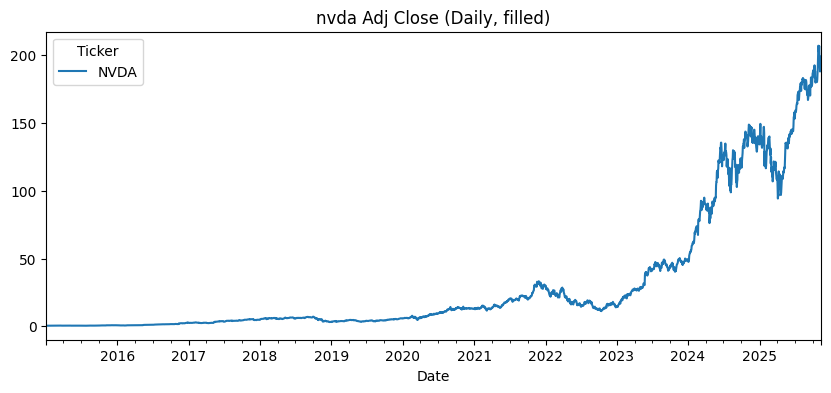

In [14]:
nvda_daily.plot(title="nvda Adj Close (Daily, filled)", figsize=(10,4))
plt.show()

In [15]:
def train_test_split_series(series: pd.Series, test_size: int = 60):
    train = series.iloc[:-test_size]
    test  = series.iloc[-test_size:]
    return train, test

def metrics(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE(%)": mape}

In [16]:
test_size = int(0.2*len(nvda_daily))
train_d, test_d = train_test_split_series(nvda_daily, test_size=test_size)
train_log,test_log = np.log(train_d),np.log(test_d)

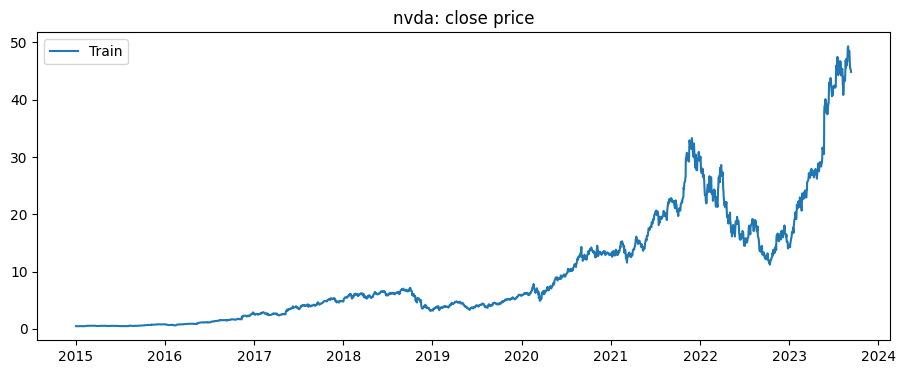

In [17]:
plt.figure(figsize=(11,4))
plt.plot(train_d, label="Train")
plt.title("nvda: close price")
plt.legend()
plt.show()

### 1. SES(Simple Exponential Smoothing)

Test Set Metrics:
MAE: 71.0598
RMSE: 82.7730
MAPE(%): 53.5752

Train Set Metrics:
MAE: 8.7200
RMSE: 13.2081
MAPE(%): 101.6765


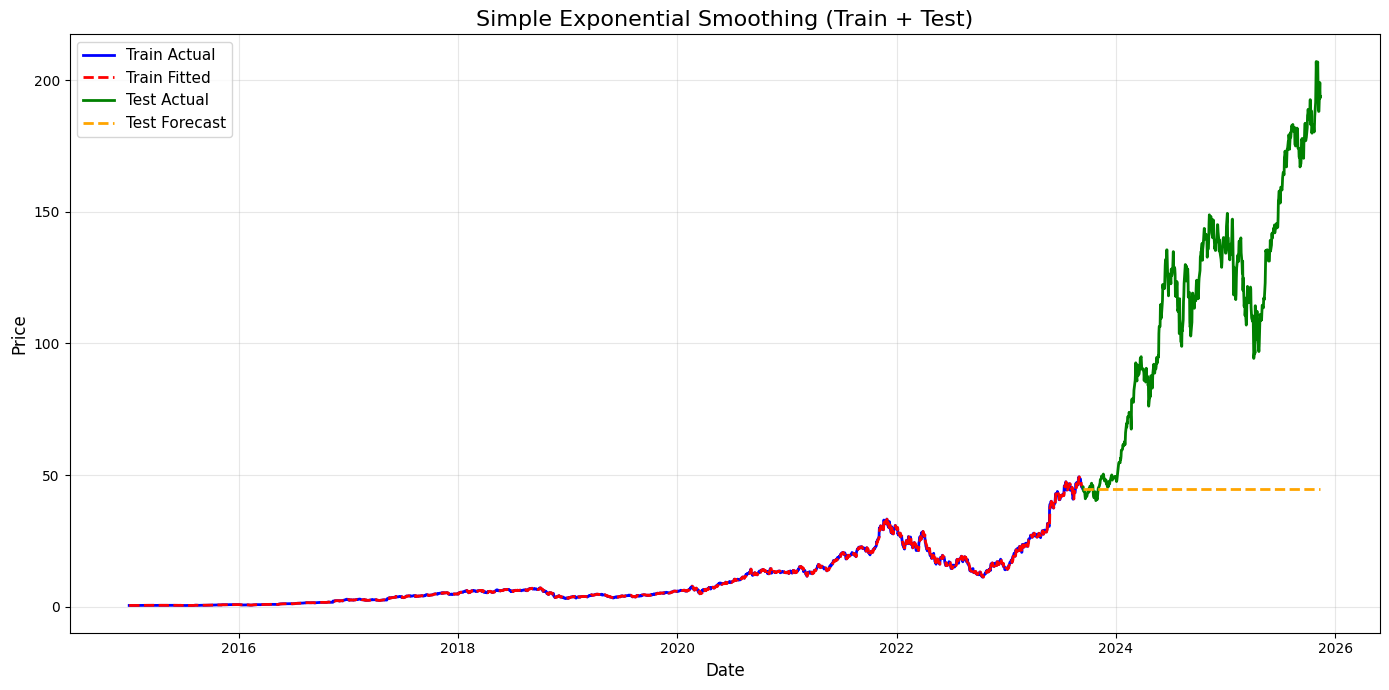

In [18]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses_auto = SimpleExpSmoothing(train_log, initialization_method="estimated").fit(optimized=True)

ses_auto_fore = ses_auto.forecast(len(test_log))
ses_auto_fore = np.exp(ses_auto_fore)
ses_auto_fore.index = test_log.index

# Eval of Test
res_ses_auto = metrics(test_d, ses_auto_fore)
print("Test Set Metrics:")
for key, value in res_ses_auto.items():
    print(f"{key}: {value:.4f}")

# Eval of Train
train_metrics = metrics(train_d, ses_auto.fittedvalues)
print("\nTrain Set Metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

# Plot: Train + Test Together

plt.figure(figsize=(14, 7))
plt.title("Simple Exponential Smoothing (Train + Test)", fontsize=16)

# Train Plot
plt.plot(train_d.index,
         train_d.values,
         label="Train Actual",
         color="blue",
         linewidth=2)

plt.plot(train_d.index,
         np.exp(ses_auto.fittedvalues),  # inverse-transform for plot
         label="Train Fitted",
         color="red",
         linestyle="--",
         linewidth=2)

# Test Plot
plt.plot(test_d.index,
         test_d.values,
         label="Test Actual",
         color="green",
         linewidth=2)

plt.plot(test_d.index,
         ses_auto_fore.values,
         label="Test Forecast",
         color="orange",
         linestyle="--",
         linewidth=2)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 2. Holt-Winter's
trend와 seasonality를 둘다 모델링하도록 Holt Winter 써봄. 이때, monthly seasonality로 만들려면 월별 데이터로 resample해야하므로 그냥 weekly seasonality로 모델링

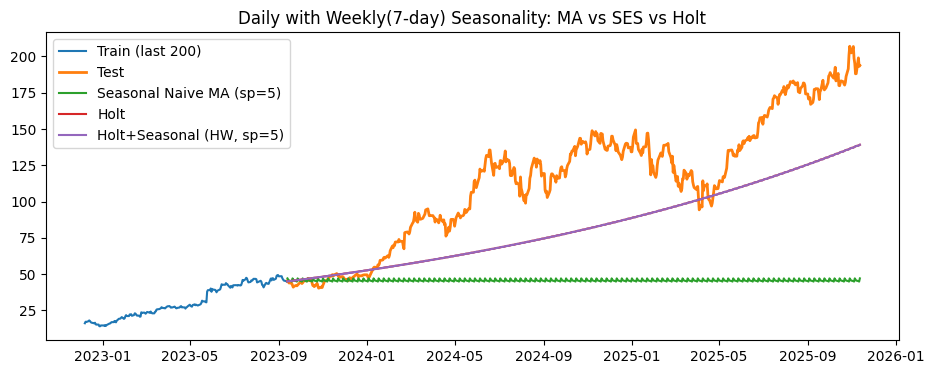

,MAE,RMSE,MAPE(%)
Holt(linear),49.434086,60.039219,44.897170
Holt(seasonal),49.434398,60.039284,44.896098
MA(seasonal),70.273184,82.011086,52.891430


In [19]:
### Holt-Winter's(Trend+Seasonality)
# seasonal naive MA (preiod=5days)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def seasonal_naive_forecast(series, season_len, steps):
    pred = []
    hist = series.values
    for i in range(steps):
        pred.append(hist[-season_len + (i % season_len)])
    return pd.Series(pred, index=pd.date_range(series.index[-1] + pd.tseries.offsets.BDay(),
                                               periods=steps, freq="B"))

ma_seasonal = seasonal_naive_forecast(train_log.astype(float), season_len=5, steps=len(test_log))
ma_seasonal = ma_seasonal.astype(float)
ma_seasonal = np.exp(ma_seasonal)

holt = ExponentialSmoothing(train_log, trend="add", seasonal=None, initialization_method="estimated").fit(optimized=True)
holt_fore = holt.forecast(len(test_log))

#log-inverse transformation
holt_fore = np.exp(holt_fore)
holt_fore.index = test_log.index

holt_seasonal = ExponentialSmoothing(train_log,
                                     trend="add",
                                     seasonal="add",
                                     seasonal_periods=5,
                                     initialization_method="estimated").fit(optimized=True)
holt_seasonal_fore = holt_seasonal.forecast(len(test_log))
holt_seasonal_fore = np.exp(holt_seasonal_fore)
holt_seasonal_fore.index = test_log.index

plt.figure(figsize=(11,4))
plt.plot(train_d[-200:], label="Train (last 200)")
plt.plot(test_d, label="Test", linewidth=2)

plt.plot(ma_seasonal, label="Seasonal Naive MA (sp=5)")
plt.plot(holt_fore, label="Holt")
plt.plot(holt_seasonal_fore, label="Holt+Seasonal (HW, sp=5)")

plt.title("Daily with Weekly(7-day) Seasonality: MA vs SES vs Holt")
plt.legend()
plt.show()


perf = {
    "MA(seasonal)": metrics(test_d, ma_seasonal),
    "Holt(linear)": metrics(test_d, holt_fore),
    "Holt(seasonal)": metrics(test_d, holt_seasonal_fore)
}
pd.DataFrame(perf).T.sort_values("RMSE")

### 3. ARIMA


In [20]:
### 7. Stationary Check(ADF Test, ACF/PACF Plots)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

adf_result = adfuller(train_log.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -0.9953363830892142
p-value: 0.7549614455046554


the series is non-stationary

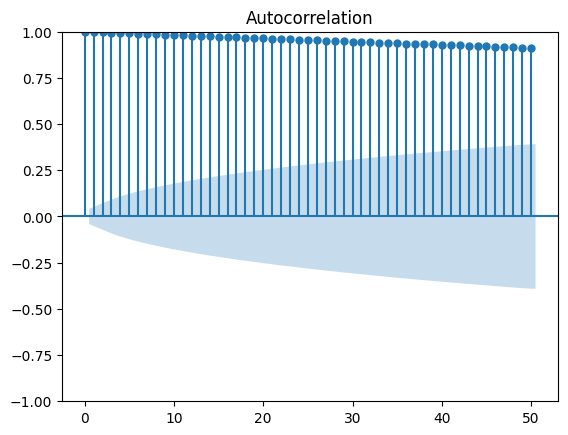

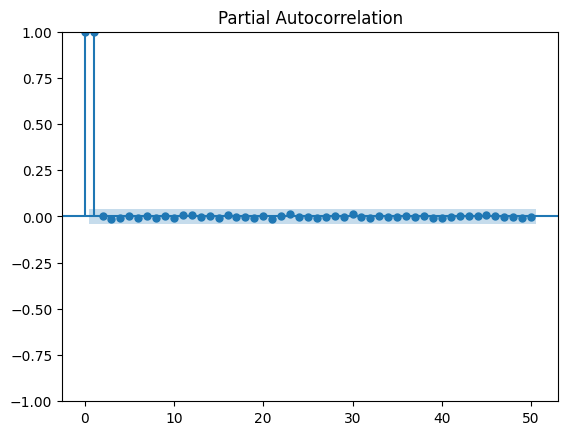

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_log.dropna(), lags=50)
plot_pacf(train_log.dropna(), lags=50)
plt.show()

그리고 ACF plot결과 seasonality도 없는 것으로 보임->만약 seasonality있다면 ACF plot에서 특정 lag 간격마다 peak가 반복되어야하고, 이때 해당 lag가 sarima 모델의 m(계절주기)에 해당하게 됨.->SARIMA대신 ARIMA 적용

In [22]:
%pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 16.1 MB/s eta 0:00:00


In [23]:
from pmdarima.arima import ndiffs
import pmdarima as pm

kpss_diffs = ndiffs(train_log, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_log, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


{'ADF': np.float64(0.7549614455046554), 'ADF diff': np.float64(2.5334983935090977e-20)}


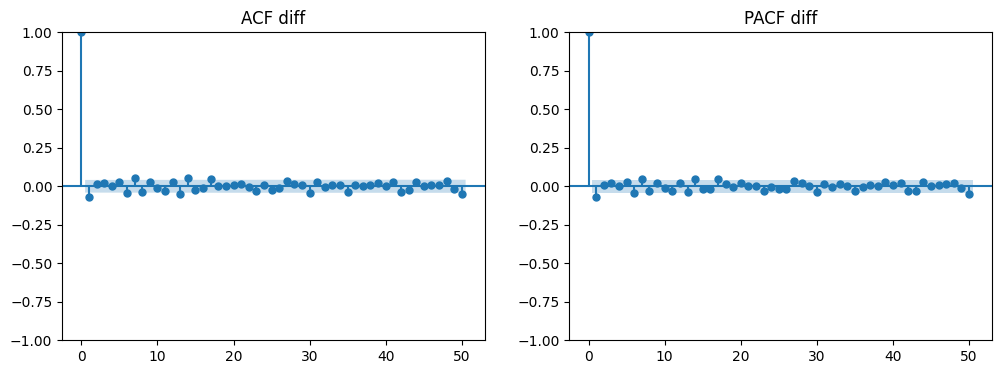

In [24]:
##그럼 first differencing 후에 stationary 인지 check->ADF test
from statsmodels.tsa.stattools import adfuller
train_diff = train_log.diff().dropna()
print({"ADF": adfuller(train_log)[1], "ADF diff": adfuller(train_diff)[1]})

fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(train_diff, ax=axes[0], lags=50)
plot_pacf(train_diff, ax=axes[1], lags=50)
axes[0].set_title("ACF diff")
axes[1].set_title("PACF diff")
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9487.454, Time=0.68 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9495.493, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9495.278, Time=2.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9479.298, Time=0.77 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9493.609, Time=2.72 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9493.560, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9491.631, Time=3.83 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-9485.939, Time=0.38 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 12.196 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2268
Model:               SARIMAX(1, 1, 0)   Log Likelihood                4750.746
Date:                Sat, 22 Nov 2025   AIC                          -9495.493
Time:                      

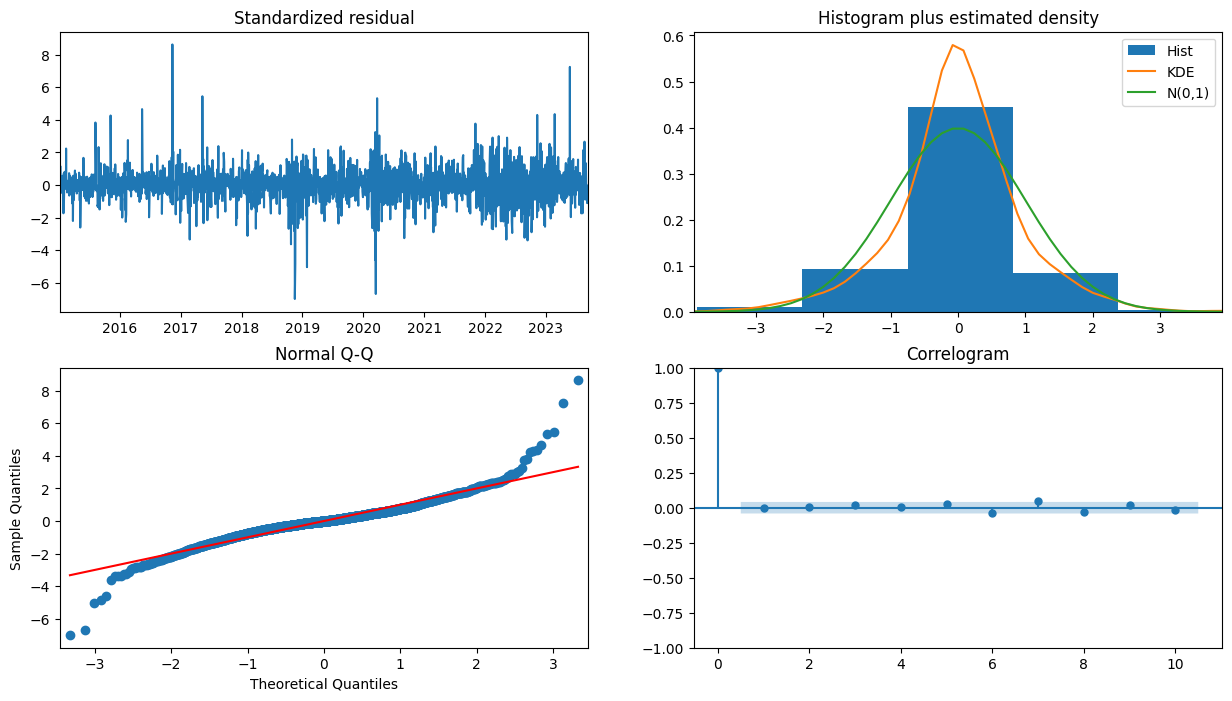

In [25]:
model_autoARIMA = pm.auto_arima(train_log, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

- **Ljung-Box(Q)**
:잔차가 백색잡음인지
검정한 통계량

- Probability = 0.98>.05 이므로 x reject null hypothesis: 잔차가 백색잡음 시계열을 따른다.
->시계열 모형이 잘 적합되었고, 남은 잔차는 더 이상 자기상관을 가지지 않는 백색 잡음이라고 해석할 수 있음.

- **Jarque-Bera(JB)**
는 잔차가 정규분포를 따르는지 검정한 통계량

- JB값을 보면 0.00로 유의수준 0,05에서 reject null hypothesis->잔차는 정규성을 따르지 않음.

->해당 arima 모델에 잔차는 정규성을 띄지 않는 백색잡음.

+ 잔차가 정규분포 따른다면, nvdaew는 0에 가까워야하고, kurtosis는 3에 가까워야함.
위의 결과에서 nvdaew는 0.19로 0에 가깝지만 kurtosis는 10.7로 3보다 더 높은 값이므로 정규분포를 따르지 않음을 알 수 있음.


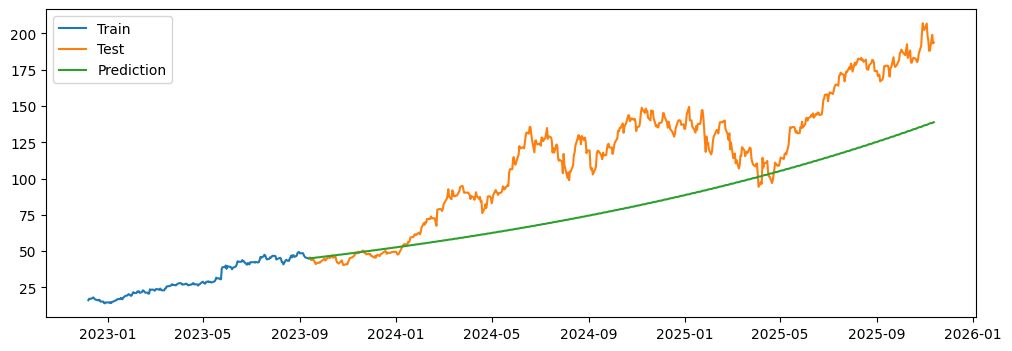

In [26]:
# 테스트 데이터 개수만큼 예측
predict_log = model_autoARIMA.predict(n_periods=len(test_log))
predict_log = pd.DataFrame(predict_log,index = test_log.index,columns=['Prediction'])
predicted_y = np.exp(predict_log)
# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(train_d[-200:], label='Train')
plt.plot(test_d, label='Test')
plt.plot(predicted_y, label='Prediction')
plt.legend()
plt.show()

In [27]:
metrics(test_d, predicted_y)

{'MAE': np.float64(33.37533066549744),
 'RMSE': np.float64(39.261125557186574),
 'MAPE(%)': np.float64(25.99004808469211)}

### 4.LSTM

In [28]:
nvda_data = nvda[['Close','High','Low','Open','Volume']].dropna(how='all').asfreq('B')
nvda_data = nvda_data.fillna(method='ffill')
nvda_data.head()

/tmp/ipython-input-3241565389.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nvda_data = nvda_data.fillna(method='ffill')


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2015-01-02,0.483038,0.486638,0.475360,0.483038,113680000.0
2015-01-05,0.474880,0.484478,0.472720,0.483038,197952000.0
2015-01-06,0.460482,0.476080,0.460002,0.475600,197764000.0
2015-01-07,0.459282,0.467921,0.457843,0.463842,321808000.0
2015-01-08,0.476559,0.479439,0.464321,0.464561,283780000.0


In [29]:
len(nvda_data)

2834

In [30]:
nvda_log = np.log(nvda_data)
nvda_log.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2015-01-02,-0.727659,-0.720235,-0.743684,-0.727659,18.548898
2015-01-05,-0.744694,-0.724683,-0.749252,-0.727659,19.103535
2015-01-06,-0.775481,-0.742170,-0.776524,-0.743179,19.102585
2015-01-07,-0.778090,-0.759456,-0.781230,-0.768212,19.589466
2015-01-08,-0.741163,-0.735139,-0.767178,-0.766661,19.463710


In [31]:
nvda_log.columns = ['log_close','log_high','log_low','log_open','log_volume']

In [32]:
nvda_log_corr_df = nvda_log.corr()

In [33]:
import seaborn as sns

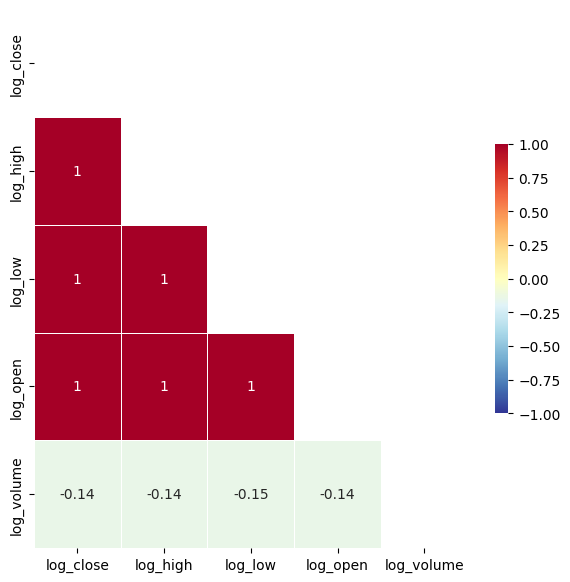

In [36]:
fig, ax = plt.subplots(figsize=(7,7))

mask = np.zeros_like(nvda_log_corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(nvda_log_corr_df,
            cmap = 'RdYlBu_r',
            annot = True,
            mask=mask,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )
plt.show()

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
nvda_log = nvda_log.drop(['log_volume'], axis=1)
nvda_log['log_close2'] = nvda_log['log_close']
nvda_log_scaled = nvda_log.copy()
nvda_log_scaled.iloc[:,:4] = scaler.fit_transform(nvda_log_scaled.iloc[:,:4])
nvda_log_scaled.head()

,log_close,log_high,log_low,log_open,log_close2
Date,,,,,
2015-01-02,-1.817700,-1.820935,-1.818582,-1.817037,-0.727659
2015-01-05,-1.828031,-1.823629,-1.821963,-1.817037,-0.744694
2015-01-06,-1.846703,-1.834224,-1.838523,-1.826447,-0.775481
2015-01-07,-1.848286,-1.844696,-1.841381,-1.841627,-0.778090
2015-01-08,-1.825890,-1.829964,-1.832848,-1.840687,-0.741163


In [38]:
from sklearn.model_selection import train_test_split
import numpy as np

def generate_dataset(df,input_idx,target_idx, window_size, test_n=90):
    x = []
    y = []

    for i in range(len(df) - window_size):
        # feature = df.iloc[rows, columns 0~3]
        input_data = df.iloc[i:i + window_size, 0:input_idx].values
        x.append(input_data)
        output_data = df.iloc[i + window_size, target_idx]
        y.append(output_data)

    x = np.array(x)
    y = np.array(y)


    # 2. Train/Test split
    test_idx = len(df) - test_n
    split_point = test_idx - window_size

    x_train = x[:split_point]
    y_train = y[:split_point]

    x_test = x[split_point:]
    y_test = y[split_point:]

    # 3. Train/Val split
    x_train, x_val, y_train, y_val = train_test_split(
        x_train, y_train,
        test_size=0.1,
        shuffle=True
    )
    print(f"# Train data: {y_train.shape[0]}")
    print(f"# Val data:   {y_val.shape[0]}")
    print(f"# Test data:  {y_test.shape[0]}")

    return x_train, y_train, x_val, y_val, x_test, y_test




     Running Window Size = 25

# Train data: 2018
# Val data:   225
# Test data:  566
Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.2951 - mae: 1.2951 - val_loss: 0.2239 - val_mae: 0.2239
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4437 - mae: 0.4437 - val_loss: 0.1464 - val_mae: 0.1464
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3727 - mae: 0.3727 - val_loss: 0.1836 - val_mae: 0.1836
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3729 - mae: 0.3729 - val_loss: 0.1647 - val_mae: 0.1647
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3151 - mae: 0.3151 - val_loss: 0.1458 - val_mae: 0.1458
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3021 - mae: 0.3021 - val_loss: 0.1509 - val_mae: 0.1509
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3048 - mae: 0.3048 - val_loss: 0.1879 - val_mae: 0.1879
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3013 - mae: 0.3013 - val

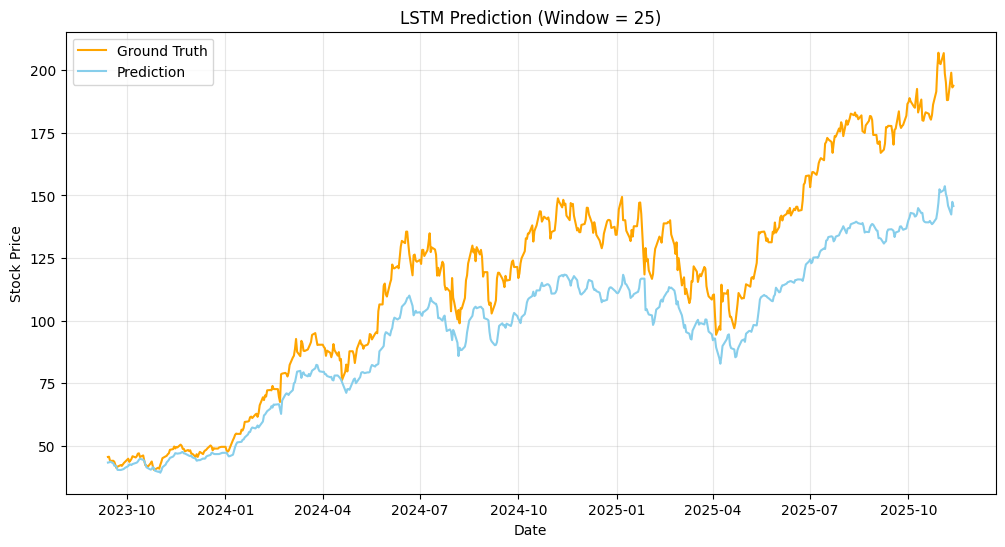


Metrics:
{'MAE': np.float64(20.397380592966247), 'RMSE': np.float64(24.381098437147415), 'MAPE(%)': np.float64(15.384086423910567)}


     Running Window Size = 50

# Train data: 1996
# Val data:   222
# Test data:  566
Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.3717 - mae: 1.3717 - val_loss: 0.2126 - val_mae: 0.2126
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.4932 - mae: 0.4932 - val_loss: 0.1387 - val_mae: 0.1387
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4015 - mae: 0.4015 - val_loss: 0.2062 - val_mae: 0.2062
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3756 - mae: 0.3756 - val_loss: 0.1378 - val_mae: 0.1378
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.3628 - mae: 0.3628 - val_loss: 0.1936 - val_mae: 0.1936
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3272 - mae: 0.3272 - val_loss: 0.0930 - val_mae: 0.0930
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3126 - ma

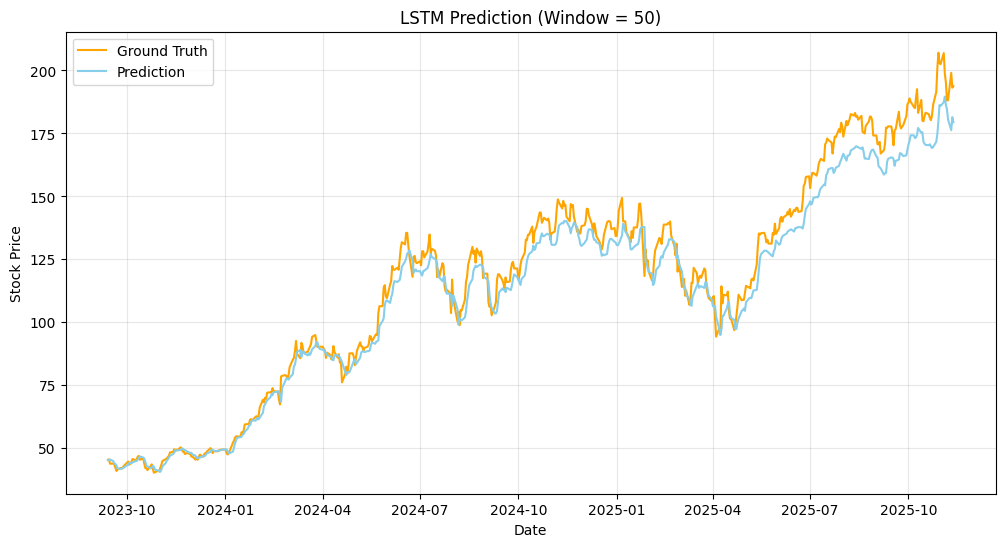


Metrics:
{'MAE': np.float64(5.682593996027754), 'RMSE': np.float64(7.443063307884628), 'MAPE(%)': np.float64(4.328288900914538)}


     Running Window Size = 100

# Train data: 1951
# Val data:   217
# Test data:  566
Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 1.4074 - mae: 1.4074 - val_loss: 0.2622 - val_mae: 0.2622
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.4989 - mae: 0.4989 - val_loss: 0.1252 - val_mae: 0.1252
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.4434 - mae: 0.4434 - val_loss: 0.1085 - val_mae: 0.1085
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.4111 - mae: 0.4111 - val_loss: 0.0887 - val_mae: 0.0887
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.3516 - mae: 0.3516 - val_loss: 0.1097 - val_mae: 0.1097
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.3569 - mae: 0.3569 - val_loss: 0.0652 - val_mae: 0.0652
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.3284 - mae:

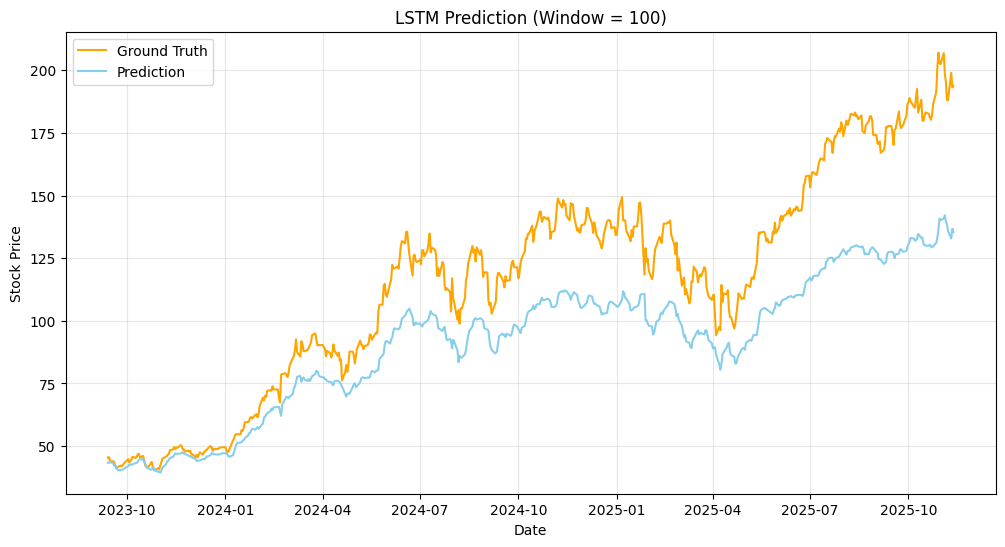


Metrics:
{'MAE': np.float64(24.48127386679498), 'RMSE': np.float64(29.378761710141593), 'MAPE(%)': np.float64(18.29790280883607)}

============== Summary ==============
Window Size 25 → Test MAE = {'MAE': np.float64(20.397380592966247), 'RMSE': np.float64(24.381098437147415), 'MAPE(%)': np.float64(15.384086423910567)}
Window Size 50 → Test MAE = {'MAE': np.float64(5.682593996027754), 'RMSE': np.float64(7.443063307884628), 'MAPE(%)': np.float64(4.328288900914538)}
Window Size 100 → Test MAE = {'MAE': np.float64(24.48127386679498), 'RMSE': np.float64(29.378761710141593), 'MAPE(%)': np.float64(18.29790280883607)}



In [40]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os


# 1. LSTM 모델

def build_lstm(input_shape):
    model = keras.Sequential([
        keras.layers.LSTM(
            64, activation='tanh',
            input_shape=input_shape,
            return_sequences=False
        ),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)
    ])
    model.compile(
        loss='mae',
        optimizer=Adam(0.001),
        metrics=['mae']
    )
    return model


def run_experiment(df,input_idx,target_idx,window_size):

    print(f"\n\n====================================")
    print(f"     Running Window Size = {window_size}")
    print(f"====================================\n")

    # 데이터 생성
    test_n = int(0.2*len(df))
    x_train, y_train, x_val, y_val, x_test, y_test = generate_dataset(df,input_idx,target_idx, window_size,test_n)


    model = build_lstm((x_train.shape[1], x_train.shape[2]))


    checkpoint_path = f"/content/best_lstm_ws_datacol{input_idx}_window{window_size}.weights.h5"

    cbk = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_mae',
        mode='min',
        save_best_only=True
    )
    es = keras.callbacks.EarlyStopping(
        patience=50,
        restore_best_weights=True
    )

    # 모델 학습
    history = model.fit(
        x_train, y_train,
        epochs=200,
        batch_size=32,
        validation_data=(x_val, y_val),
        callbacks=[cbk, es],
        verbose=1
    )


    model.load_weights(checkpoint_path)
    score = model.evaluate(x_test, y_test, verbose=0)
    print("\nTest MAE:", score[1])
    y_pred = model.predict(x_test)


    #Date index 추출
    test_idx = len(df) - test_n
    split_point = test_idx - window_size
    test_start_index = split_point + window_size
    date_index_for_test = df.index[test_start_index : test_start_index + len(y_test)]

     #inverse transform
    y_test = np.exp(y_test)
    y_pred = np.exp(y_pred)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(date_index_for_test, y_test, label='Ground Truth', color='orange')
    plt.plot(date_index_for_test, y_pred, label='Prediction', color='skyblue')
    plt.title(f'LSTM Prediction (Window = {window_size})')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    result = metrics(y_test, y_pred.flatten())

    print("\nMetrics:")
    print(result)

    return result


results = {}
for ws in [25, 50, 100]:
    results[ws] = run_experiment(nvda_log_scaled,4,4,ws)

print("\n============== Summary ==============")
for ws, mae in results.items():
    print(f"Window Size {ws} → Test MAE = {mae}")
print("=====================================\n")




     Running Window Size = 25

# Train data: 2018
# Val data:   225
# Test data:  566
Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.4291 - mae: 1.4291 - val_loss: 0.1810 - val_mae: 0.1810
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3773 - mae: 0.3773 - val_loss: 0.1388 - val_mae: 0.1388
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3095 - mae: 0.3095 - val_loss: 0.1095 - val_mae: 0.1095
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2993 - mae: 0.2993 - val_loss: 0.1279 - val_mae: 0.1279
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3061 - mae: 0.3061 - val_loss: 0.0660 - val_mae: 0.0660
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3002 - mae: 0.3002 - val_loss: 0.1541 - val_mae: 0.1541
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2963 - mae: 0.2963 - val_loss: 0.1206 - val_mae: 0.1206
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2919 - mae: 0.2919 - val

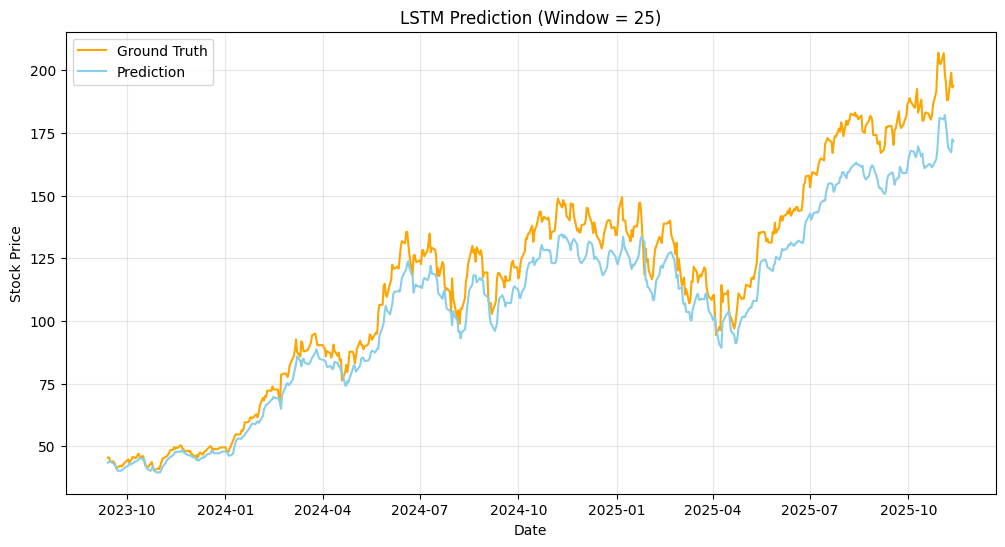


Metrics:
{'MAE': np.float64(10.034247988104397), 'RMSE': np.float64(12.02927269093945), 'MAPE(%)': np.float64(7.787153271262735)}


     Running Window Size = 50

# Train data: 1996
# Val data:   222
# Test data:  566
Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 1.3721 - mae: 1.3721 - val_loss: 0.1268 - val_mae: 0.1268
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.3840 - mae: 0.3840 - val_loss: 0.0844 - val_mae: 0.0844
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3178 - mae: 0.3178 - val_loss: 0.1348 - val_mae: 0.1348
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.2983 - mae: 0.2983 - val_loss: 0.0885 - val_mae: 0.0885
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2850 - mae: 0.2850 - val_loss: 0.1781 - val_mae: 0.1781
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2909 - mae: 0.2909 - val_loss: 0.0619 - val_mae: 0.0619
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2561 - mae:

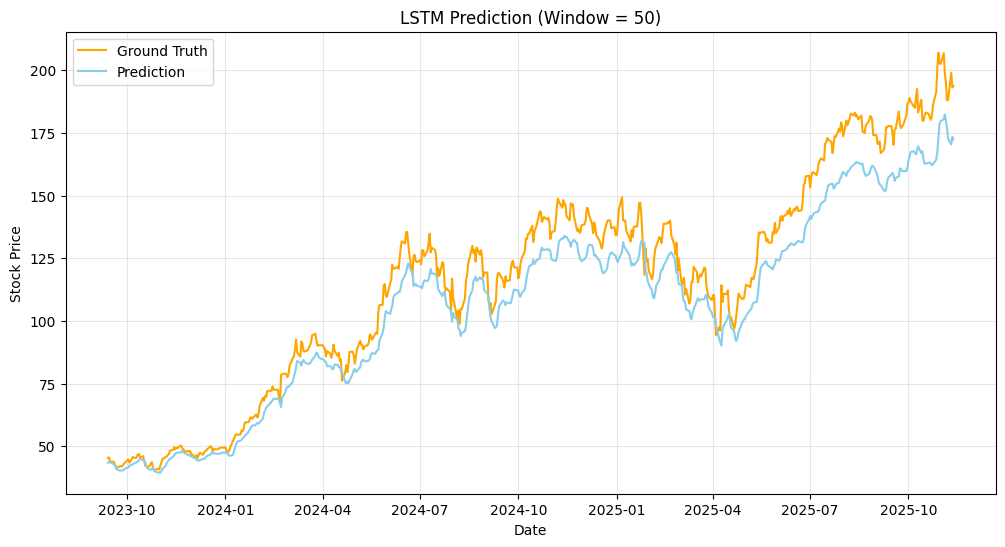


Metrics:
{'MAE': np.float64(10.17583016708967), 'RMSE': np.float64(12.110025046196418), 'MAPE(%)': np.float64(8.005196217651715)}


     Running Window Size = 100

# Train data: 1951
# Val data:   217
# Test data:  566
Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 1.3808 - mae: 1.3808 - val_loss: 0.3118 - val_mae: 0.3118
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.4605 - mae: 0.4605 - val_loss: 0.1810 - val_mae: 0.1810
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.3356 - mae: 0.3356 - val_loss: 0.1446 - val_mae: 0.1446
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.3272 - mae: 0.3272 - val_loss: 0.1043 - val_mae: 0.1043
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.2907 - mae: 0.2907 - val_loss: 0.0636 - val_mae: 0.0636
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2634 - mae: 0.2634 - val_loss: 0.0872 - val_mae: 0.0872
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.2658 - mae

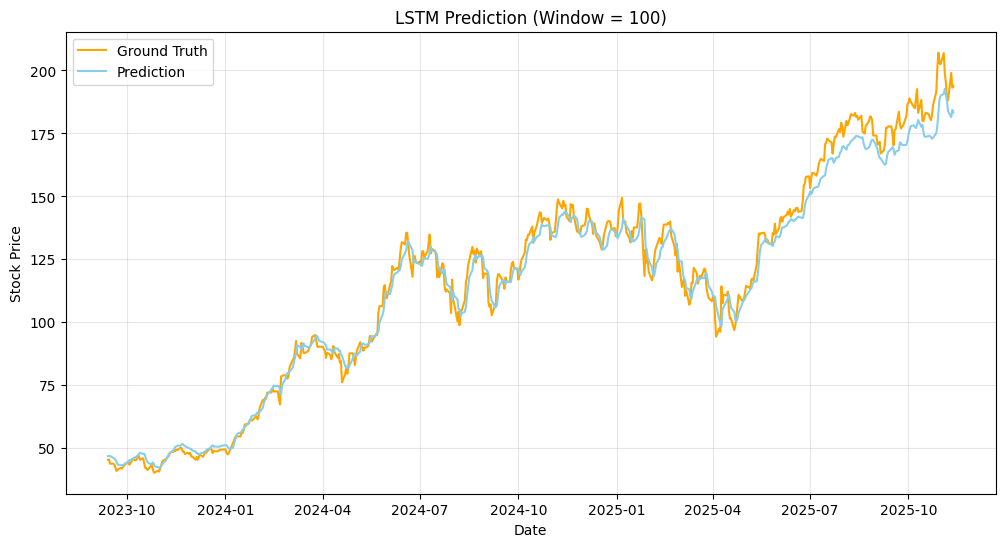


Metrics:
{'MAE': np.float64(4.161193227599449), 'RMSE': np.float64(5.572878129606684), 'MAPE(%)': np.float64(3.4544258497653835)}

============== Summary ==============
Window Size 25 → Test MAE = {'MAE': np.float64(10.034247988104397), 'RMSE': np.float64(12.02927269093945), 'MAPE(%)': np.float64(7.787153271262735)}
Window Size 50 → Test MAE = {'MAE': np.float64(10.17583016708967), 'RMSE': np.float64(12.110025046196418), 'MAPE(%)': np.float64(8.005196217651715)}
Window Size 100 → Test MAE = {'MAE': np.float64(4.161193227599449), 'RMSE': np.float64(5.572878129606684), 'MAPE(%)': np.float64(3.4544258497653835)}



In [41]:
#종가 단일 데이터로 LSTM prediction
results2 = {}
for ws in [25, 50, 100]:
    results2[ws] = run_experiment(nvda_log_scaled,1,4,ws)

print("\n============== Summary ==============")
for ws, mae in results2.items():
    print(f"Window Size {ws} → Test MAE = {mae}")
print("=====================================\n")

** LSTM result**
time dependency 기준을 영업일(5)에 대해 각각 5주(=25),10주(=50),20주(=100)으로 나눠서 돌려봄
- 1)open,close,high,low 데이터->close예측:window_size=50이 best
- 2)close단일->close예측:window size=100이 best
->sk hynix와 비교했을 때 좀 더 장기적으로 변하는 패턴
->단일 데이터 예측 성능이 더 좋게 나옴.